In [296]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Seasonal Data

In [449]:
df_all = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/2015_snowfall.csv')

In [452]:
if type(df_all.day_of_week[0]) != int:
    df_all = day_of_week_col(df_all)

In [453]:
df_all.head()

,new_24,basedepth,open_trails,open_lifts,open_percent,mon_day,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot,day_of_week
date,,,,,,,,,,,,,,
2015-11-15,1.3,18.0,2.50,2.25,2.25,15-Nov,1.3,9.1,1.3,3.9,5.2,6.5,7.8,6
2015-11-16,1.3,18.0,3.00,2.50,2.50,16-Nov,2.6,9.1,2.6,3.9,5.2,6.5,7.8,0
2015-11-17,1.3,19.5,3.25,2.50,2.75,17-Nov,3.9,9.1,2.6,3.9,5.2,6.5,7.8,1
2015-11-18,1.3,18.0,3.75,2.50,2.00,18-Nov,5.2,9.1,2.6,3.9,5.2,6.5,7.8,2
2015-11-19,1.3,18.0,6.60,2.60,2.80,19-Nov,6.5,9.1,2.6,3.9,5.2,6.5,7.8,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129775090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12aa43510>]], dtype=object)

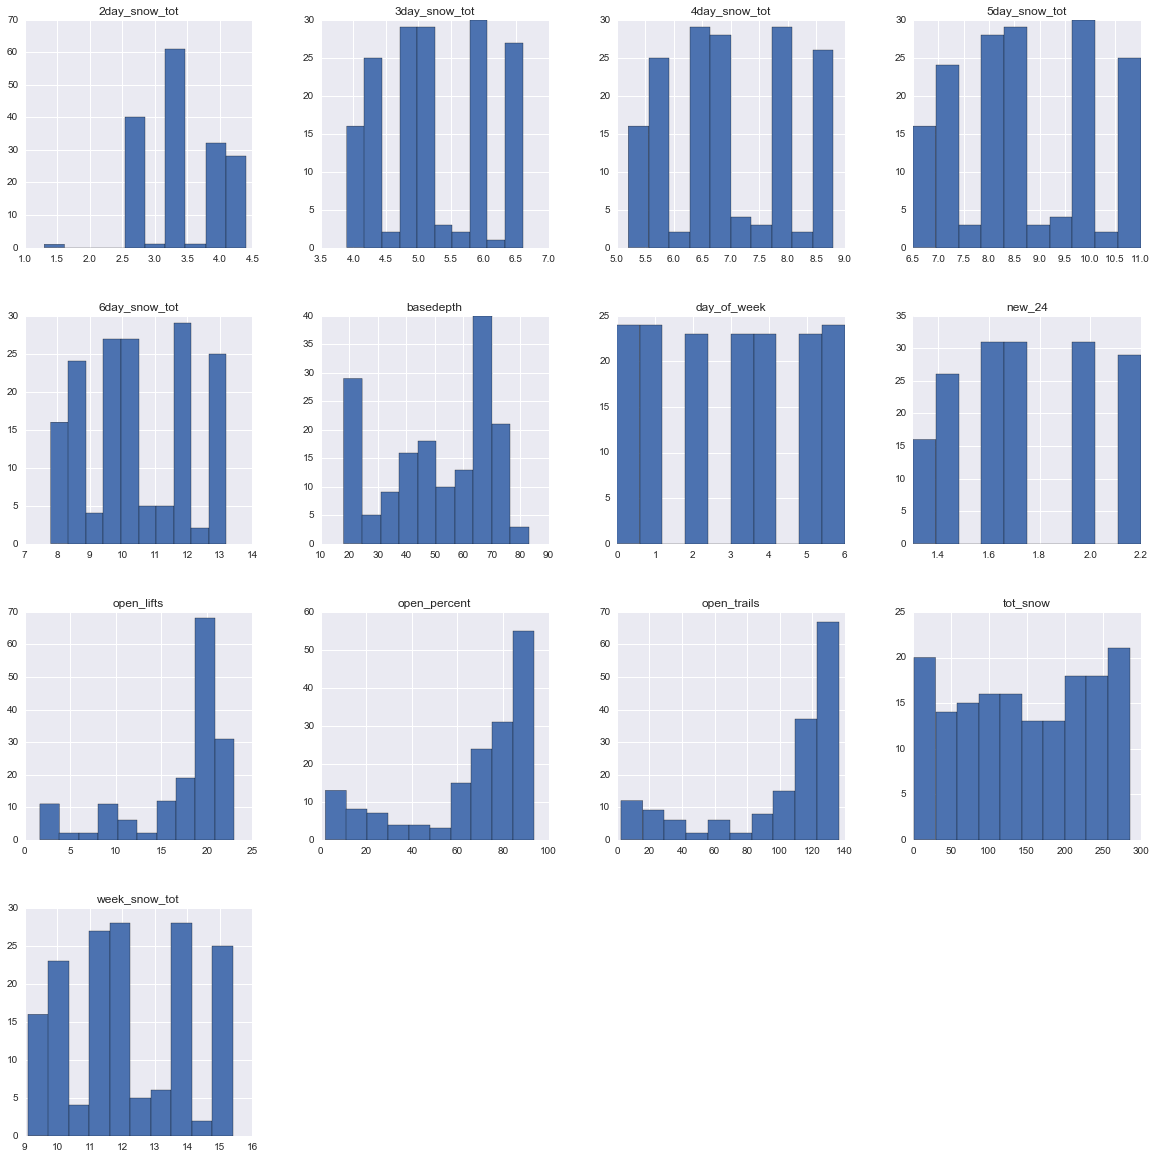

In [454]:
df_all.hist(figsize=(20,20), xlabelsize = 10, ylabelsize = 10)

#### Create a crowd yesterday column

In [455]:
#df_all['crowd_yest'] = df_all.skiers.shift(1)

#### Create dummy variables for days of the week.

In [456]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.day_of_week, prefix='day')], axis=1)

In [457]:
df_all.head()

,new_24,basedepth,open_trails,open_lifts,open_percent,mon_day,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,5day_snow_tot,6day_snow_tot,day_of_week,day_0,day_1,day_2,day_3,day_4,day_5,day_6
date,,,,,,,,,,,,,,,,,,,,,
2015-11-15,1.3,18.0,2.50,2.25,2.25,15-Nov,1.3,9.1,1.3,3.9,...,6.5,7.8,6,0,0,0,0,0,0,1
2015-11-16,1.3,18.0,3.00,2.50,2.50,16-Nov,2.6,9.1,2.6,3.9,...,6.5,7.8,0,1,0,0,0,0,0,0
2015-11-17,1.3,19.5,3.25,2.50,2.75,17-Nov,3.9,9.1,2.6,3.9,...,6.5,7.8,1,0,1,0,0,0,0,0
2015-11-18,1.3,18.0,3.75,2.50,2.00,18-Nov,5.2,9.1,2.6,3.9,...,6.5,7.8,2,0,0,1,0,0,0,0
2015-11-19,1.3,18.0,6.60,2.60,2.80,19-Nov,6.5,9.1,2.6,3.9,...,6.5,7.8,3,0,0,0,1,0,0,0


### Drop day of week column

In [458]:
df_all = df_all.drop(['day_of_week'], axis=1)

#### Make month column

In [459]:
df_all['month'] = df_all.index.month

In [460]:
df_all = pd.concat([df_all, pd.get_dummies(df_all.month, prefix='month')], axis=1)

In [461]:
df_all.drop(['month'], axis=1, inplace=True)

#### Make holiday features

In [462]:
L = len(df_all)-1
holidays = get_holiday_list(df_all.index[0].year, df_all.index[0].month, df_all.index[0].day, df_all.index[L].year, df_all.index[L].month, df_all.index[L].day)

In [463]:
vet_day, thanksgiv, xmas, new_years, mlk_day, pres_day = get_holiday_names(holidays)

In [464]:
df_try = call_make_holiday_columns(df_all, vet_day, thanksgiv, xmas, new_years, mlk_day, pres_day)

In [465]:
pd.options.display.max_rows = 999

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [466]:
df_all['new_years_sat'] = df_all.filter(regex="day_5")*df_all.new_years
df_all['mlk_sat'] = df_all.filter(regex="day_5")*df_all.mlk_day

In [467]:
df_all['new_years_sun'] = df_all.filter(regex="day_6")*df_all.new_years
df_all['mlk_sun'] = df_all.filter(regex="day_6")*df_all.mlk_day

In [468]:
df_all['new_years_fri'] = df_all.filter(regex="day_4")*df_all.new_years
df_all['mlk_fri'] = df_all.filter(regex="day_4")*df_all.mlk_day

In [469]:
df_all['new_years_mon'] = df_all.filter(regex="day_0")*df_all.new_years
df_all['mlk_mon'] = df_all.filter(regex="day_0")*df_all.mlk_day

### Make spring break column

In [470]:
df_all = make_spring_break_col(df_all, holidays, 'hol_name')

In [471]:
df_all = make_spring_trailing_weeks(df_all, holidays, 'hol_name')

In [472]:
df_all.fillna(df_all.mean(), inplace=True)

,new_24,basedepth,open_trails,open_lifts,open_percent,mon_day,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
date,,,,,,,,,,,,,,,,,,,,,
2015-11-15,1.3,18.000000,2.500000,2.250000,2.250000,15-Nov,1.3,9.1,1.3,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-16,1.3,18.000000,3.000000,2.500000,2.500000,16-Nov,2.6,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-17,1.3,19.500000,3.250000,2.500000,2.750000,17-Nov,3.9,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-18,1.3,18.000000,3.750000,2.500000,2.000000,18-Nov,5.2,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-19,1.3,18.000000,6.600000,2.600000,2.800000,19-Nov,6.5,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-20,1.3,18.000000,4.333333,1.666667,3.333333,20-Nov,7.8,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-21,1.3,18.000000,7.000000,2.333333,5.000000,21-Nov,9.1,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-22,1.3,18.000000,5.800000,3.000000,4.400000,22-Nov,10.4,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2015-11-23,1.3,18.500000,8.500000,3.000000,3.750000,23-Nov,11.7,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0


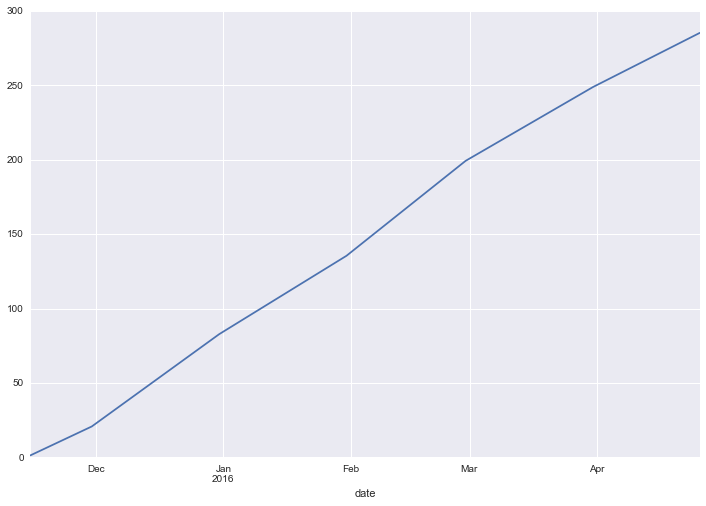

In [473]:
df_all.tot_snow.plot()

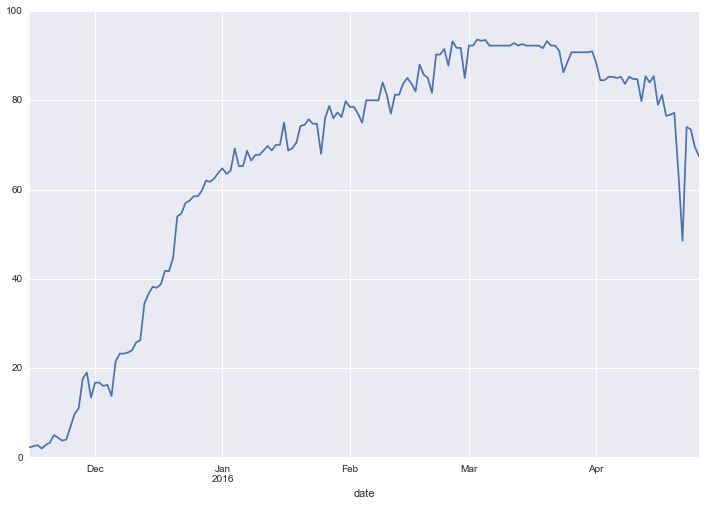

In [474]:
df_all.open_percent.plot()

# Export Data

In [475]:
df_all.to_csv('../data_ski_in_solitude/all_15_16_feat.csv')